**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2022*

----
Alumnos:
- Mauricio Caggia
- Francisco Furey
- Luciano Monforte
- Alejandro Pitton
----
# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('talk')
from sqlalchemy import create_engine, text
import plotly
plotly.__version__
import missingno as msno
import pandas_profiling
%matplotlib inline
import plotly.express as px

In [2]:
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

In [3]:
interesting_cols=['description','neighborhood_overview','street','neighborhood','city','suburb',
                 'state','zipcode','price','weekly_price','monthly_price','latitude','longitude']
airbnb_df=pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
                     usecols=interesting_cols,low_memory=False)
airbnb_df['zipcode']=pd.to_numeric(airbnb_df.zipcode,errors='coerce')

## Ejercicio 1 SQL: 

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.

4. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



# Procedemos a ver la primera fila de cada una de las tablas a usar. 

In [4]:
airbnb_df.head(1)

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.0,-37.772684,145.092133,60,NaN,NaN


In [5]:
# Estudiamos las características de ambas bases a utilizar (M) #
# En Melb son precios de venta y en airbnb de alquileres?(M) # Si, asi es. En Melb precio de Vta y en Airbnb alquileres temporarios (L)
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            22563 non-null  object 
 1   neighborhood_overview  14424 non-null  object 
 2   street                 22895 non-null  object 
 3   neighborhood           17082 non-null  object 
 4   city                   22895 non-null  object 
 5   suburb                 22872 non-null  object 
 6   state                  22834 non-null  object 
 7   zipcode                22749 non-null  float64
 8   latitude               22895 non-null  float64
 9   longitude              22895 non-null  float64
 10  price                  22895 non-null  int64  
 11  weekly_price           2524 non-null   float64
 12  monthly_price          1891 non-null   float64
dtypes: float64(5), int64(1), object(7)
memory usage: 2.3+ MB


In [6]:
airbnb_df.zipcode.value_counts()

3000.0     3367
3006.0     1268
3182.0     1135
3141.0      881
3004.0      728
           ... 
3785.0        1
3096.0        1
30122.0       1
3912.0        1
4068.0        1
Name: zipcode, Length: 247, dtype: int64

In [7]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [8]:
melb_df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


# Creamos la conexion a la base de datos.

In [9]:
engine=create_engine('sqlite:///grupo13.sqlite3',echo=True)
engine

Engine(sqlite:///grupo13.sqlite3)

# Cargamos las dos tablas a la base de datos creada.


In [10]:
melb_df.to_sql(name='melb_df',con=engine,if_exists='replace',index=False);
airbnb_df.to_sql(name='airbnb_df',con=engine,if_exists='replace',index=False);

2022-07-17 19:09:11,330 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb_df")
2022-07-17 19:09:11,341 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:11,351 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("melb_df")
2022-07-17 19:09:11,353 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:11,376 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-07-17 19:09:11,387 INFO sqlalchemy.engine.Engine 
CREATE TABLE melb_df (
	"Suburb" TEXT, 
	"Address" TEXT, 
	"Rooms" BIGINT, 
	"Type" TEXT, 
	"Price" FLOAT, 
	"Method" TEXT, 
	"SellerG" TEXT, 
	"Date" TEXT, 
	"Distance" FLOAT, 
	"Postcode" FLOAT, 
	"Bedroom2" FLOAT, 
	"Bathroom" FLOAT, 
	"Car" FLOAT, 
	"Landsize" FLOAT, 
	"BuildingArea" FLOAT, 
	"YearBuilt" FLOAT, 
	"CouncilArea" TEXT, 
	"Lattitude" FLOAT, 
	"Longtitude" FLOAT, 
	"Regionname" TEXT, 
	"Propertycount" FLOAT
)


2022-07-17 19:09:11,390 INFO sqlalchemy.engine.Engine [no key 0.00314s] ()
2022-07-17 19:09:11,409 INFO sqlalchemy.engine.Engine COMM

# Procedemos a leer la primera fila de cada tabla, pero esta vez sacandola desde la base de datos creada (para comprobar que fue cargada correctamente).

In [11]:
df=pd.read_sql_table("melb_df",engine);
df1=pd.read_sql_table("airbnb_df",engine);

2022-07-17 19:09:16,314 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2022-07-17 19:09:16,320 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:16,324 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2022-07-17 19:09:16,333 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:16,339 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb_df")
2022-07-17 19:09:16,346 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:16,357 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2022-07-17 19:09:16,367 INFO sqlalchemy.engine.Engine [raw sql] ('melb_df',)
2022-07-17 19:09:16,373 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("melb_df")
2022-07-17 19:09:16,377 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:16,380 INFO sqlalchemy.engine.Engine PRAG

In [12]:
#guardamos una copia antes de las transformaciones que le aplicaremos (M)#
airbnb_df2=airbnb_df.copy()

# Aqui abajo vemos la primera fila de la tabla melb_df, y confirmamos que coincide tal como queremos

In [13]:
df.head(1)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0


# Aqui abajo vemos la primera fila de la tabla airbnb_df, y confirmamos que coincide tal como queremos

In [14]:
df1.head(1)

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.0,-37.772684,145.092133,60,NaN,NaN


# 3)a- Cantidad de registros totales por ciudad.

In [15]:
query="""
SELECT
  city,
  count(*) AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY city
ORDER BY count(*) DESC 
"""
pd.read_sql_query(query,engine)

2022-07-17 19:09:18,220 INFO sqlalchemy.engine.Engine 
SELECT
  city,
  count(*) AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY city
ORDER BY count(*) DESC 

2022-07-17 19:09:18,233 INFO sqlalchemy.engine.Engine [raw sql] ()


,city,Cantidad_de_registros
0,Melbourne,7368
1,Port Phillip,2808
2,Yarra,2049
3,Stonnington,1621
4,Moreland,967
5,Yarra Ranges,771
6,Darebin,698
7,Boroondara,664
8,Glen Eira,631
9,Whitehorse,614


## 3)b- Cantidad de registros totales por barrio y ciudad.

In [16]:
query1="""
SELECT
  city                  AS Ciudad,
  neighborhood          AS Barrio,
  count(*)              AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY Ciudad, Barrio
ORDER BY count(*) DESC
"""
pd.read_sql_query(query1,engine)

2022-07-17 19:09:18,334 INFO sqlalchemy.engine.Engine 
SELECT
  city                  AS Ciudad,
  neighborhood          AS Barrio,
  count(*)              AS Cantidad_de_registros 
FROM airbnb_df
GROUP BY Ciudad, Barrio
ORDER BY count(*) DESC

2022-07-17 19:09:18,338 INFO sqlalchemy.engine.Engine [raw sql] ()


,Ciudad,Barrio,Cantidad_de_registros
0,Melbourne,Central Business District,3726
1,Melbourne,Southbank,1204
2,Port Phillip,St Kilda,1082
3,Yarra Ranges,None,771
4,Stonnington,South Yarra,759
...,...,...,...
129,Bayside,Bentleigh,1
130,Bayside,Elwood,1
131,Melbourne,South Melbourne,1
132,Moonee Valley,Kensington,1


# 4 Combinamos los datasets mediante comando de JOIN

In [17]:
airbnb_df.sample(3)

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
21466,NaN,NaN,"Fitzroy North, VIC, Australia",Fitzroy North,Yarra,Fitzroy North,VIC,3068.0,-37.783202,144.992260,55,NaN,NaN
12413,The location of the apartment is very good and...,NaN,"Melbourne, VIC, Australia",Carlton,Melbourne,Melbourne,VIC,3000.0,-37.801980,144.957953,105,NaN,NaN
15054,An ENTIRE 2-BEDROOM apartment unit ALL TO YOUR...,Immensely convenient surroundings. We're situa...,"Melbourne, VIC, Australia",Central Business District,Melbourne,Melbourne,VIC,3004.0,-37.807990,144.959202,125,NaN,NaN


In [18]:
airbnb_df2['zipcode']=pd.to_numeric(airbnb_df2.zipcode,errors='coerce')
relevant_cols =['price','weekly_price','monthly_price']
airbnb_df2 = airbnb_df2[relevant_cols + ['zipcode']].groupby('zipcode').mean().reset_index()
airbnb_df2.to_sql(name='airbnb_df2',con=engine,if_exists='replace', index=True);


2022-07-17 19:09:18,569 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("airbnb_df2")
2022-07-17 19:09:18,573 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:18,583 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("airbnb_df2")
2022-07-17 19:09:18,589 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-07-17 19:09:18,594 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-07-17 19:09:18,599 INFO sqlalchemy.engine.Engine 
CREATE TABLE airbnb_df2 (
	"index" BIGINT, 
	zipcode FLOAT, 
	price FLOAT, 
	weekly_price FLOAT, 
	monthly_price FLOAT
)


2022-07-17 19:09:18,605 INFO sqlalchemy.engine.Engine [no key 0.00729s] ()
2022-07-17 19:09:18,622 INFO sqlalchemy.engine.Engine CREATE INDEX ix_airbnb_df2_index ON airbnb_df2 ("index")
2022-07-17 19:09:18,623 INFO sqlalchemy.engine.Engine [no key 0.00174s] ()
2022-07-17 19:09:18,642 INFO sqlalchemy.engine.Engine COMMIT
2022-07-17 19:09:18,647 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-07-17 19:09:18,658 INFO sqlalchemy.en

In [19]:
query2="""
SELECT * 
FROM melb_df LEFT JOIN airbnb_df2 ON melb_df.Postcode=airbnb_df2.zipcode;
"""
pd.read_sql_query(query2,engine)

2022-07-17 19:09:18,692 INFO sqlalchemy.engine.Engine 
SELECT * 
FROM melb_df LEFT JOIN airbnb_df2 ON melb_df.Postcode=airbnb_df2.zipcode;

2022-07-17 19:09:18,694 INFO sqlalchemy.engine.Engine [raw sql] ()


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,index,zipcode,price,weekly_price,monthly_price
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,605.152174,2187.032258
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,605.152174,2187.032258
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,605.152174,2187.032258
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,605.152174,2187.032258
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,57.0,3067.0,130.624031,605.152174,2187.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,125.0,3150.0,124.026455,526.350000,1901.611111
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,None,-37.85927,144.87904,Western Metropolitan,6380.0,14.0,3016.0,191.094595,612.250000,2119.750000
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,None,-37.85274,144.88738,Western Metropolitan,6380.0,14.0,3016.0,191.094595,612.250000,2119.750000
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,None,-37.85908,144.89299,Western Metropolitan,6380.0,14.0,3016.0,191.094595,612.250000,2119.750000


## Ejercicio 2: 

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar las columnas seleccionadas y las que no lo fueron.
 - Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

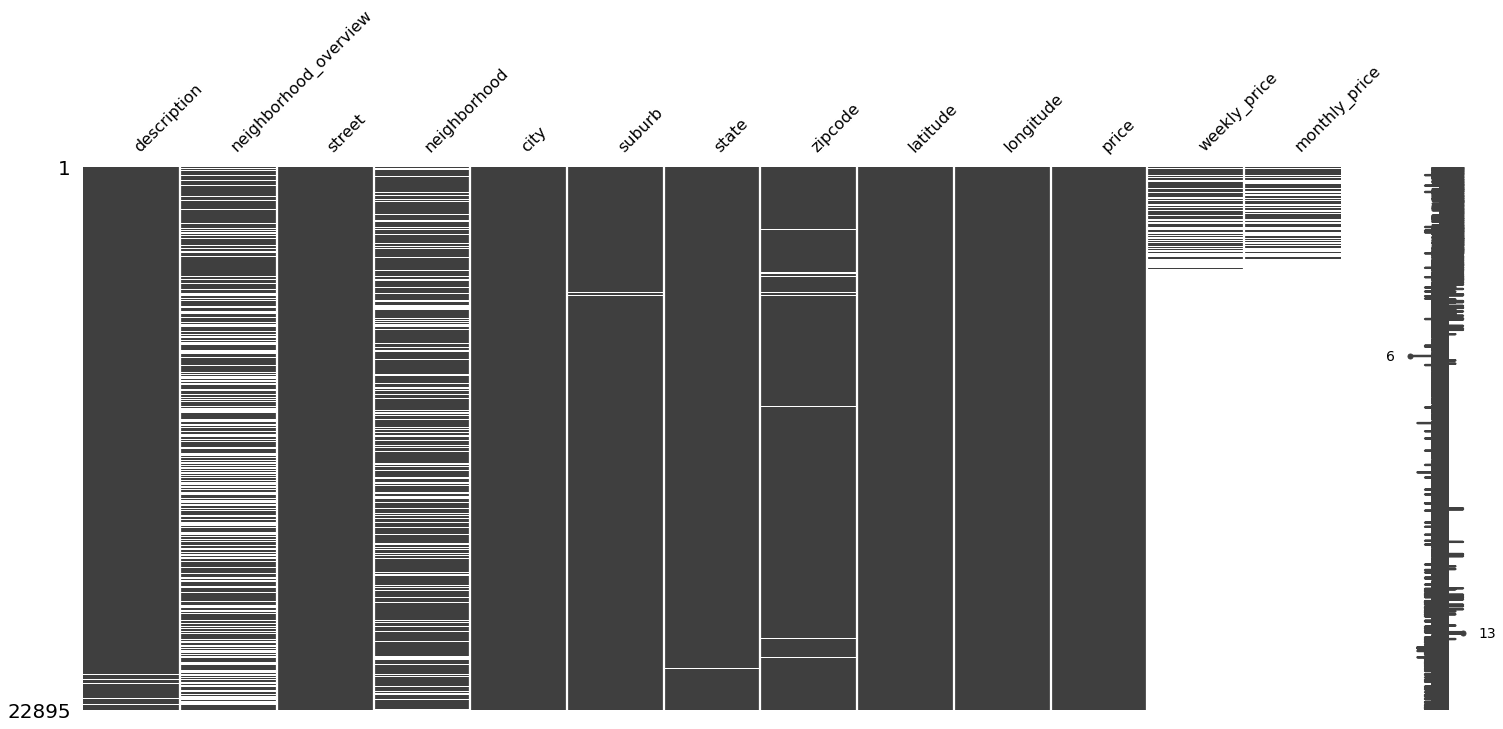

In [20]:
import missingno as msno
msno.matrix(airbnb_df);

In [21]:
# Creamos una base que tenga solo los datos que tienen missing en neiborghood_overview
df_00 = airbnb_df.fillna(0)
df_10 = df_00.loc[df_00.neighborhood_overview == 0]

In [22]:
# Observamos la relación media de los datos que tienen missing en neiborhood_overview respecto de la base total 
1-(df_10.price.mean()/airbnb_df.price.mean())

0.0185332737972852

En este gráfico de datos perdidos de la base de airbnb, observamos que en cuanto a precio solo podremos utilizar el diario, debido a que los precios semanales y mensuales tienen un altísimo nivel de datos perdidos. Por otro lado, a pesar de la cantidad de datos faltantes de "Neighborhood_overview" (37%), la utilizaremos por que la consideramos muy importante para definir el valor de un inmueble. La pérdida de datos en la variable "neiborhood_overview" parece ser aleatoria, debido a que la media de precio diario de los valores perdidos difiere en menos de un 2% a la media de la base completa.

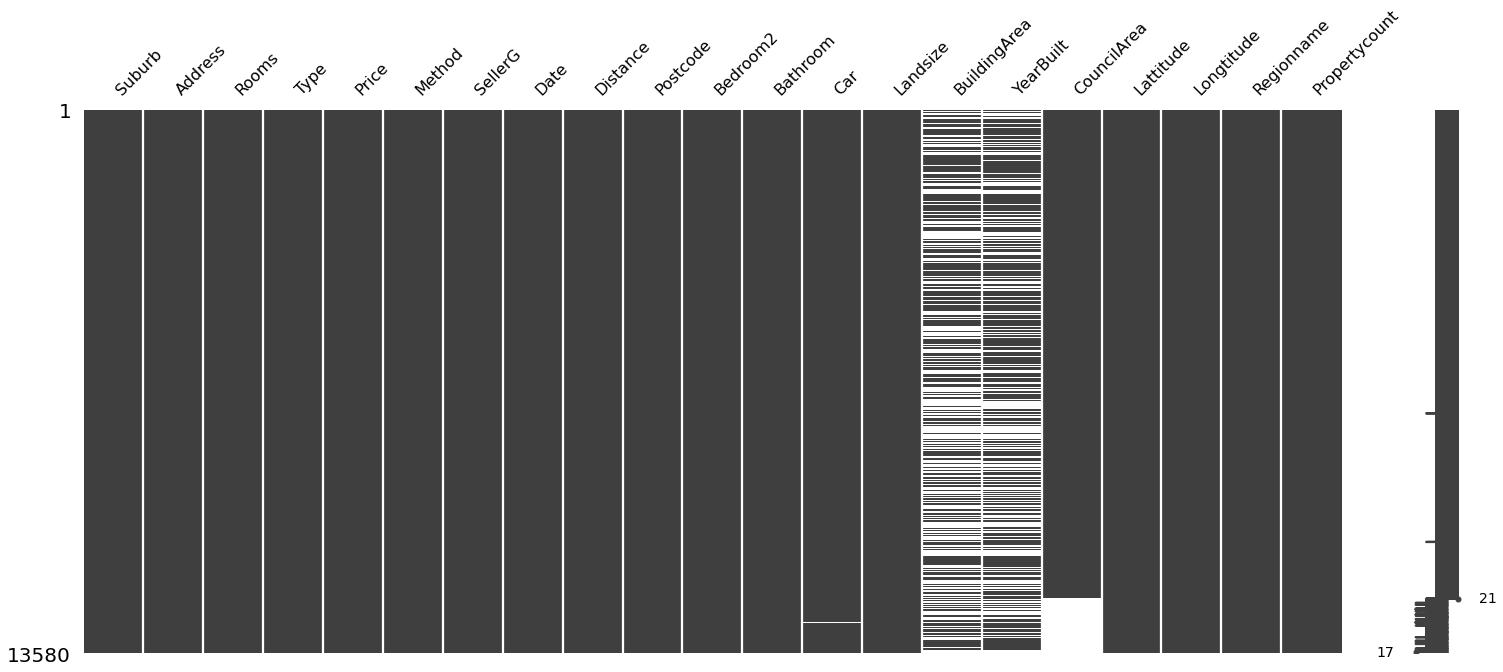

In [23]:
msno.matrix(melb_df);

In [24]:
df_Melb00 = melb_df.fillna(0)
df_Melb10 = df_Melb00.loc[df_Melb00.BuildingArea == 0]

In [25]:
# Observamos la relación media de los datos que tienen missing en BuildingArea respecto de la base total 
1-(df_Melb10.Price.mean()/melb_df.Price.mean())

0.003432452395705665

En relación a los datos perdidos de la base de Melbourne, podemos decir que los únicos campos con problemas de pérdida de datos son BuildingArea y YearBuilt, con lo cual en un principio los dejaremos de lado pero luego haremos tareas de imputación para nutrir la base debido a su importancia. La pérdida de datos en la variable "BuildingArea" parece ser aleatoria, debido a que la media de precio de los valores perdidos difiere en menos de un 0,4% a la media de la base completa.

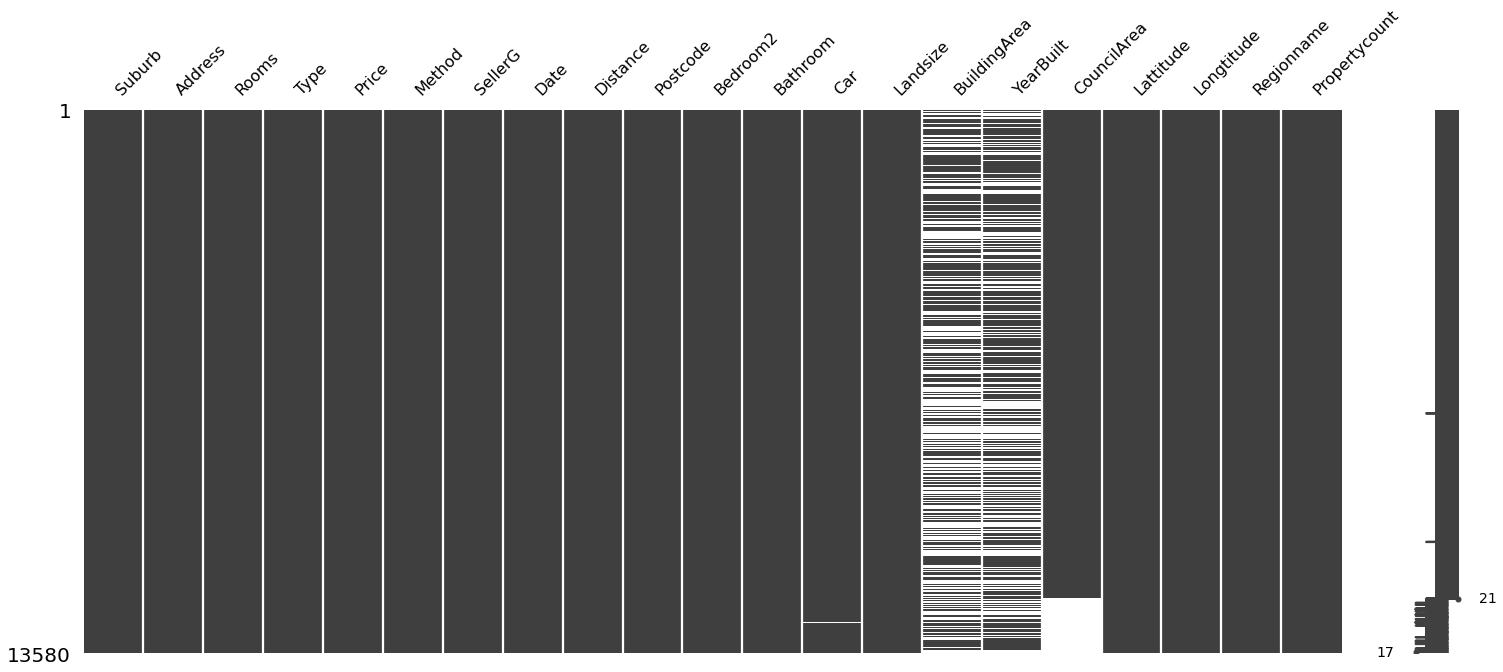

In [26]:
melb_df.sort_values('Price')
msno.matrix(melb_df)

            Rooms  Bedroom2
Rooms     1.00000   0.94419
Bedroom2  0.94419   1.00000
Coef de correlación entra ambas variables:  0.94 



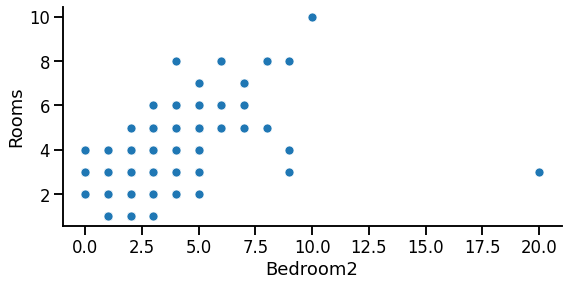

In [27]:
#calculamos la correlacion entre las columnas rooms y Bedroom2 porque por el nombre parecen indicar el mismo dato
sns.pairplot(data=melb_df, y_vars=['Rooms'],
                 x_vars=['Bedroom2'],
                 aspect=2, height=4)
corr_df = melb_df[['Rooms','Bedroom2']].corr()
print(corr_df)
print('Coef de correlación entra ambas variables: ', round(corr_df.iloc[0]['Bedroom2'],2) ,'\n')

In [30]:
#Vemos la cantidad de registros por barrio en a  base de Melb
query_melb_suburb="""
SELECT
  Suburb,
  count(*) AS Cantidad_de_registros 
FROM melb_df
GROUP BY Suburb
ORDER BY count(*) DESC 
LIMIT 20
"""
pd.read_sql_query(query_melb_suburb,engine)

2022-07-17 19:14:06,291 INFO sqlalchemy.engine.Engine 
SELECT
  Suburb,
  count(*) AS Cantidad_de_registros 
FROM melb_df
GROUP BY Suburb
ORDER BY count(*) DESC 
LIMIT 20

2022-07-17 19:14:06,298 INFO sqlalchemy.engine.Engine [raw sql] ()


,Suburb,Cantidad_de_registros
0,Reservoir,359
1,Richmond,260
2,Bentleigh East,249
3,Preston,239
4,Brunswick,222
5,Essendon,220
6,South Yarra,202
7,Glen Iris,195
8,Hawthorn,191
9,Coburg,190


Text(0.5, 1.0, 'Distribución de los precios de las propiedades por barrio')

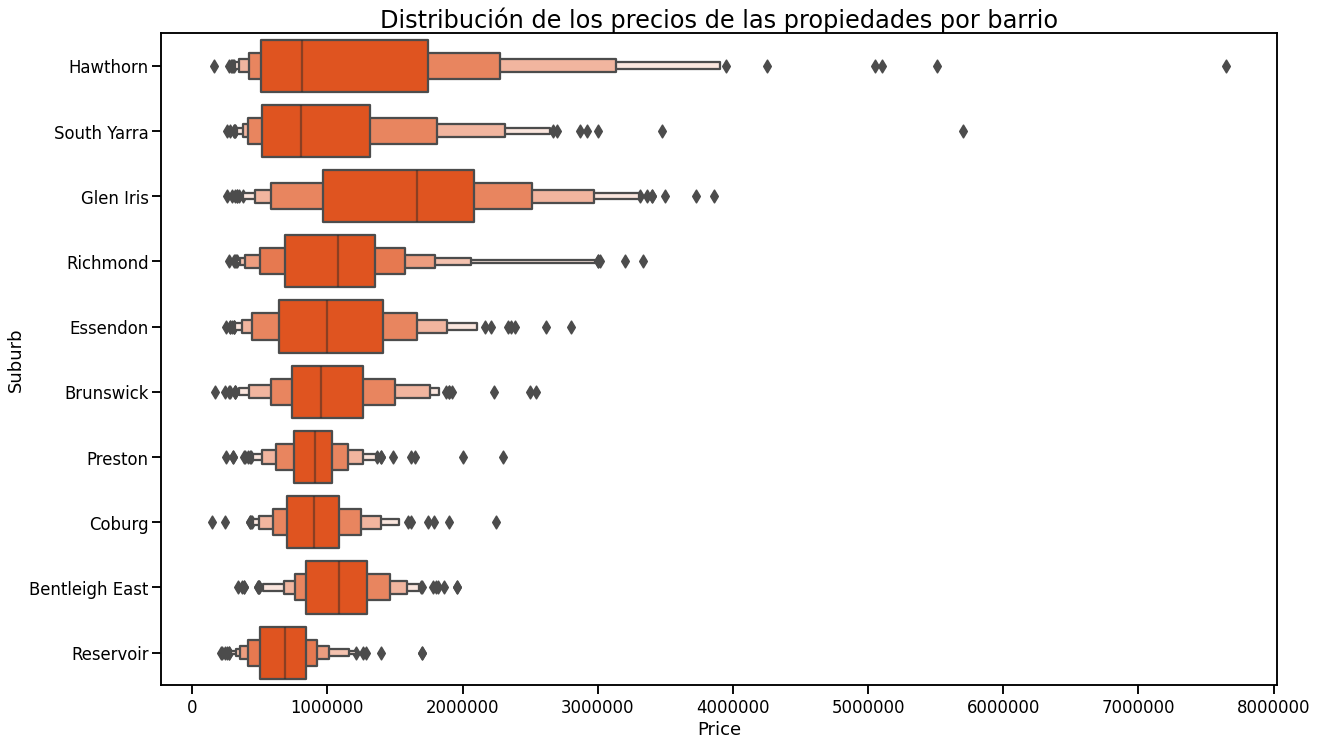

In [34]:
# ver de hacer gráfico de cajas para justificar que los precios de las casas son semejantes
df_plot = melb_df.sort_values('Price', ascending =False)
df_plot = df_plot[(df_plot['Suburb'] == 'Reservoir') |
                  (df_plot['Suburb'] == 'Richmond') |
                  (df_plot['Suburb'] == 'Bentleigh East') |
                  (df_plot['Suburb'] == 'Preston') | 
                  (df_plot['Suburb'] == 'Brunswick') | 
                  (df_plot['Suburb'] == 'Essendon') | 
                  (df_plot['Suburb'] == 'South Yarra') | 
                  (df_plot['Suburb'] == 'Glen Iris') | 
                  (df_plot['Suburb'] == 'Hawthorn') | 
                  (df_plot['Suburb'] == 'Coburg')]

plt.figure(figsize=(20, 12))
sns.boxenplot(data=df_plot, x='Price', y='Suburb',
               color='orangered')
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('Suburb')
plt.xlabel('Price')
plt.title('Distribución de los precios de las propiedades por barrio', size = 24)

In [ ]:
df_plot

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12094,Mulgrave,35 Bevis St,3,h,9000000.0,PI,Hall,29/07/2017,18.8,3170.0,...,1.0,1.0,744.0,117.0,1960.0,Monash,-37.93168,145.16126,South-Eastern Metropolitan,7113.0
7692,Canterbury,49 Mangarra Rd,5,h,8000000.0,VB,Sotheby's,13/05/2017,9.0,3126.0,...,5.0,4.0,2079.0,464.3,1880.0,Boroondara,-37.81790,145.06940,Southern Metropolitan,3265.0
9575,Hawthorn,49 Lisson Gr,4,h,7650000.0,S,Abercromby's,17/06/2017,5.3,3122.0,...,2.0,4.0,1690.0,284.0,1863.0,Boroondara,-37.82652,145.03052,Southern Metropolitan,11308.0
3616,Kew,15 Barry St,6,h,6500000.0,S,Jellis,13/08/2016,5.6,3101.0,...,6.0,3.0,1334.0,365.0,1890.0,Boroondara,-37.80290,145.02670,Southern Metropolitan,10331.0
12557,Middle Park,136 Page St,5,h,6400000.0,S,Marshall,9/09/2017,3.0,3206.0,...,2.0,1.0,553.0,308.0,1920.0,NaN,-37.84908,144.95753,Southern Metropolitan,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7940,Hawthorn,17/17 Park St,1,u,160000.0,VB,HAR,8/04/2017,4.6,3122.0,...,1.0,0.0,322.0,NaN,2009.0,Boroondara,-37.81980,145.03730,Southern Metropolitan,11308.0
7303,Albion,8/6 Ridley St,1,u,145000.0,PI,Biggin,28/05/2016,13.9,3020.0,...,1.0,1.0,36.0,NaN,NaN,Brimbank,-37.78330,144.82660,Western Metropolitan,2185.0
1927,Coburg,171 Moreland Rd,4,h,145000.0,PI,Jellis,4/06/2016,7.8,3058.0,...,1.0,1.0,536.0,164.0,1910.0,Moreland,-37.75550,144.96580,Northern Metropolitan,11204.0
1805,Caulfield,30 Pyne St,4,h,131000.0,PI,Rodney,25/02/2017,8.9,3162.0,...,1.0,2.0,499.0,155.0,1920.0,Glen Eira,-37.88640,145.02420,Southern Metropolitan,2379.0


# Selección de columnas de melb_df
### Procedemos a eliminar la variable Address porque cuenta con una alta cardinalidad, que no nos sirve para el estudio actual.
### Eliminamos tambien la variable Bedroom2, ya que existe la variable Rooms, que apunta al mismo dato (cantidad de cuartos o piezas en cada casa). 
### Eliminamos la variable SellerG, donde tan solo sale el nombre del vendedor, dato que no nos sirve y trae una alta cardinalidad
### Eliminamos las variables BuildingArea y YearBuilt por tener gran cantidad de Nans. 
### Link del Excel donde se detalla la justificación de la selección de variables: https://docs.google.com/spreadsheets/d/17VmyocYCaa7pjUqVKAwUFhX34499nhZs/edit?usp=sharing&ouid=106561172859044487281&rtpof=true&sd=true

In [ ]:
melb_df=melb_df.drop(['Address', 'Method', 'Date', 'CouncilArea', 'Lattitude', 'Longtitude','Bedroom2','SellerG'],axis=1)

### Estudiando los precios del dataset, decidimos eliminar el percentil 99% de los datos; ya que modificaba mucho la media. 
### No se eliminan valores de "Precio de Venta" bajos porque no consideramos que sean outliers. 

In [ ]:
melb_df['Price'].describe().apply(lambda s: '{0:.2f}'.format(s))

count      13580.00
mean     1075684.08
std       639310.72
min        85000.00
25%       650000.00
50%       903000.00
75%      1330000.00
max      9000000.00
Name: Price, dtype: object

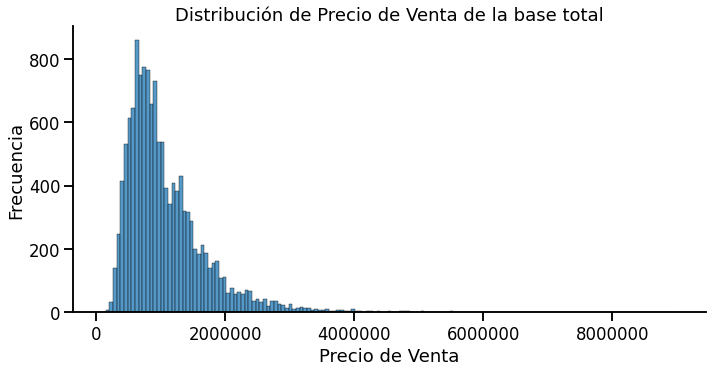

In [ ]:
sns.displot(melb_df['Price'], aspect=2) 
plt.ylabel('Frecuencia')
plt.xlabel('Precio de Venta')
plt.title('Distribución de Precio de Venta de la base total')
plt.ticklabel_format(style='plain', axis='x')

In [ ]:
melb_df= melb_df[melb_df['Price'] < melb_df['Price'] .quantile(0.99)]

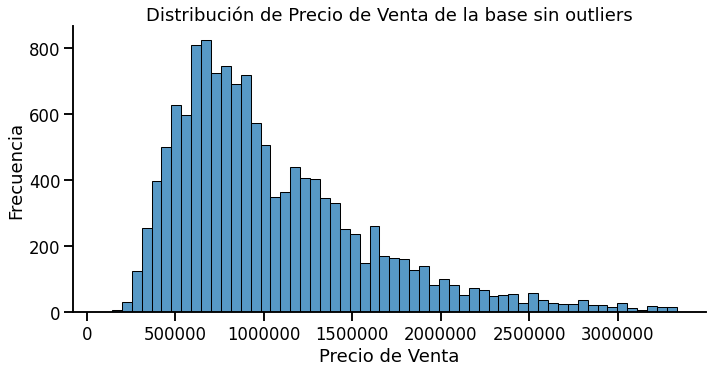

In [ ]:
sns.displot(melb_df['Price'], aspect=2) 
plt.ylabel('Frecuencia')
plt.xlabel('Precio de Venta')
plt.title('Distribución de Precio de Venta de la base sin outliers')

plt.ticklabel_format(style='plain', axis='x')

# Selección de columnas de airbnb_df
### Decidimos elegir las columnas

In [ ]:
airbnb_df2 = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')
interesting_cols = [
  'description', 'neighborhood_overview',
  'street','neighborhood', 'city', 'suburb', 'state',
  'zipcode','price', 'weekly_price', 'monthly_price',
  'review_scores_value','review_scores_location']
airbnb_df2 = airbnb_df2[interesting_cols]
airbnb_df2.head()
airbnb_df2['zipcode'] = pd.to_numeric(airbnb_df2.zipcode, errors='coerce')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (35,77) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Utilizaremos el precio y los reviews del valor y la localización
### Elegimos estos campos porque consideramos que el precio de alquiler diario está íntimamente relacionado con el precio de venta de la vivienda y ambos review dan cuenta del nivel tanto de la propiedad como de los alredores, ergo entendemos que son buenos drivers para determinar los precios de venta.

In [ ]:
airbnb_df2[['price','review_scores_value','review_scores_location']].describe().T

,count,mean,std,min,25%,50%,75%,max
price,22895.0,148.004368,210.883253,0.0,71.0,111.0,165.0,12624.0
review_scores_value,17160.0,9.478205,0.892818,2.0,9.0,10.0,10.0,10.0
review_scores_location,17162.0,9.714078,0.697961,2.0,10.0,10.0,10.0,10.0


## Crearemos un df agrupado con la media de los tres datos y agrupados por zipcode para luego unirla al df de Melbourne 

In [ ]:
relevant_cols = ['price','review_scores_value','review_scores_location', 'zipcode']

airbnb_price_by_zipcode = airbnb_df2[relevant_cols].groupby('zipcode')\
  .agg({'price': ['mean', 'count'], 'review_scores_value': 'mean',
        'review_scores_location': 'mean'})\
  .reset_index()

airbnb_price_by_zipcode.columns = [
  ' '.join(col).strip()
  for col in airbnb_price_by_zipcode.columns.values]

airbnb_price_by_zipcode = airbnb_price_by_zipcode.rename(
    columns={'price mean': 'airbnb_price_mean',
             'price count': 'airbnb_record_count',
             'review_scores_value mean': 'review_scores_value_mean',
             'review_scores_location mean': 'review_scores_location_mean'}
)
print(f"Long: {len(airbnb_price_by_zipcode)}")
airbnb_price_by_zipcode.describe()

Long: 247


,zipcode,airbnb_price_mean,airbnb_record_count,review_scores_value_mean,review_scores_location_mean
count,247.000000,247.000000,247.000000,235.000000,235.000000
mean,3508.538462,149.900412,92.101215,9.544932,9.534643
std,1903.914390,84.872988,261.914701,0.324120,0.372290
min,2010.000000,37.000000,1.000000,7.500000,7.500000
25%,3072.500000,93.744681,8.500000,9.417289,9.333333
50%,3148.000000,126.012987,27.000000,9.571429,9.575758
75%,3589.500000,187.168478,73.000000,9.725338,9.831200
max,30122.000000,759.083333,3367.000000,10.000000,10.000000


## Nos quedamos con los zipcodes que tengan una cantidad minima de 8 registros ya que el 25% de los código postales cuenta con más de 8,5 registros. Tomamos esta decisión con el objetivo de no recortar en demasia la base ya que si nos  basamos en el tamaño de muestra mínimo aceptable (30) como para que una inferencia tenga un grado de confiabilidad teniendo en cuenta la distribución T de Student, deberías eliminar más de la mitad de los registros. Entonces nos quedamos con 191 de 247 códigos postales.

In [ ]:
airbnb_price_by_zipcode = airbnb_price_by_zipcode[(airbnb_price_by_zipcode.airbnb_record_count >= 8)]
print(f"Long: {len(airbnb_price_by_zipcode)}")
airbnb_price_by_zipcode.describe()

Long: 191


,zipcode,airbnb_price_mean,airbnb_record_count,review_scores_value_mean,review_scores_location_mean
count,191.000000,191.000000,191.000000,191.000000,191.000000
mean,3210.837696,146.629092,118.083770,9.509135,9.511659
std,249.775773,85.518172,292.955885,0.256171,0.336869
min,3000.000000,49.000000,8.000000,8.285714,7.857143
25%,3065.500000,94.213675,20.500000,9.387960,9.317540
50%,3134.000000,119.914894,41.000000,9.555556,9.552381
75%,3186.500000,171.956773,96.500000,9.658022,9.800000
max,3977.000000,759.083333,3367.000000,10.000000,10.000000


## Quitamos los registros que cuenten con valores nulos

In [ ]:
airbnb_price_by_zipcode = airbnb_price_by_zipcode.dropna()

# Procedemos a unir los datasets en uno solo, para conseguir mayor información disponible

In [ ]:
merged_sales_df = melb_df.merge(
    airbnb_price_by_zipcode, how='left',
    left_on='Postcode', right_on='zipcode'
)
print(merged_sales_df.columns)
print(len(merged_sales_df))
merged_sales_df[:5]

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Distance', 'Postcode', 'Bathroom',
       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname',
       'Propertycount', 'zipcode', 'airbnb_price_mean', 'airbnb_record_count',
       'review_scores_value_mean', 'review_scores_location_mean'],
      dtype='object')
13444


,Suburb,Rooms,Type,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname,Propertycount,zipcode,airbnb_price_mean,airbnb_record_count,review_scores_value_mean,review_scores_location_mean
0,Abbotsford,2,h,1480000.0,2.5,3067.0,1.0,1.0,202.0,NaN,NaN,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
1,Abbotsford,2,h,1035000.0,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
2,Abbotsford,3,h,1465000.0,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
3,Abbotsford,3,h,850000.0,2.5,3067.0,2.0,1.0,94.0,NaN,NaN,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115
4,Abbotsford,4,h,1600000.0,2.5,3067.0,1.0,2.0,120.0,142.0,2014.0,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,9.572115,9.697115


In [ ]:
merged_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13444 entries, 0 to 13443
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Suburb                       13444 non-null  object 
 1   Rooms                        13444 non-null  int64  
 2   Type                         13444 non-null  object 
 3   Price                        13444 non-null  float64
 4   Distance                     13444 non-null  float64
 5   Postcode                     13444 non-null  float64
 6   Bathroom                     13444 non-null  float64
 7   Car                          13382 non-null  float64
 8   Landsize                     13444 non-null  float64
 9   BuildingArea                 7040 non-null   float64
 10  YearBuilt                    8112 non-null   float64
 11  Regionname                   13444 non-null  object 
 12  Propertycount                13444 non-null  float64
 13  zipcode         

Otras variables que pueden servir para combinar los datos son `'type'` y  `'property_type'`. En la columna `'type'` de **melb_df** hay solamente 3 tipos diferentes y categorizados por la primera letra en estos son: House (h), Unit (u) y Townhouse (t), mientras que en `'property_type'` de **airbnb_df** hay como 35 tipos diferentes entre los cuales se pueden encontrar House y Townhouse. Como Unit puede abarcar muchas propiedades, decidimos no tomarla en la combinación, para no proveer información errónea. Los datos de **airbnb_df** se pueden agrupar en estos dos conjuntos, House y Townhouse, y tomar las medias de los precios. Como se hizo anteriormente con `'zipcode'`. Creemos que sería adecuado, ya que al combinar los datos permite una mayor información en el caso en que alguien quiera invertir en comprar una casa para luego ponerla en alquiler por airbnb.

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [ ]:
merged_sales_df.to_csv(index=False);

In [ ]:
#BAJAMOS LA BASE PARA PODER UTILIZARLA EN EL PROXIMO ENTREGABLE#
merged_sales_df.to_csv("merged_sales_df.csv", index=None)
from google.colab import files
files.download('merged_sales_df.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>